### Neural Network Code

The only functions of importance when being used are `fit` and `predict`, which can be used like almost any model in 
`scikit-learn`. 

Everything else is a helper method, and `Layer` is a helper class. I have included comments on how this code works. Please delete the sections marked delete after you understand them. I'll modify this file and my notes to you guys shortly before submission as well.

Things to note:
- `nodes` can be either an array or a single number. If you give an array, it must be the same length as `layers`
- `activation` can only be a function. This implementation does not accept multiple activation functions
- `loss` must return an nx1 array, and must assume its inputs are also nx1
- Both `activation` and `loss` must have the parameter `derivative`, where when set to true, returns the derivative given the inputs it receives
- The print_iter argument in fit allows to see what number error we are appending to the error array as an estimation of time left in a non_cluttering manner.

- Please look at my example down below if you want to write a custom function, but I already implemented the functions that Professor Ventura said was best for this project


In [538]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import sys
import copy
import math

In [528]:
class Layer:
    # essentially a container to hold stored values across layers in forward propogation
    def __init__(self, h_x = None, sigma_h_x = None):
        self.h_x = h_x
        self.sigma_h_x = sigma_h_x


class NeuralNetwork:
    
    def __init__(self, layers, nodes, activation, loss, learning_rate, batch_size, anneal):
        
        # number of hidden layers we are creating
        self.num_layers = layers
        
        # number of nodes at each layer
        self.nodes = self._create_nodes(nodes,layers)
        
        # activation function
        self.sigma = activation
                
        # loss function
        self.loss = loss
        
        # learning rate for stochastic gradient descent
        self.lr = learning_rate
        self.true_lr = learning_rate
        # batch size for stochastic gradient descent
        self.batch_size = batch_size

        # after fit, will contain a dictionary of weights for the layers
        self.weight_dict = None
        
        # store values for backwards propagation
        self.stored = None
        
        self.anneal = anneal

        
    def _create_nodes(self, nodes, layers):
        # if given a number, creates an array with layers amount of nodes
        # otherwise returns the array of nodes
        # in both cases increments by 1 to account for bias
        if isinstance(nodes, int):
            return [nodes]*(layers)
        
        else:
            if len(nodes) != self.num_layers:
                raise Exception("Node array length does not match number of layers")
            return nodes
        
    def _create_weights(self,  num_features):
        
        zero_weight = np.random.normal(scale=math.sqrt(2/num_features) ,size=(num_features,self.nodes[0]))

        self.weight_dict = {
            
            0: np.vstack((np.zeros(self.nodes[0]),zero_weight))
        }
        
        for i in range(1,self.num_layers):
            
            weight = np.random.normal(scale=math.sqrt(2/num_features) ,size=(self.nodes[i-1],self.nodes[i]))
            self.weight_dict[i] = np.vstack((np.zeros(self.nodes[i]), weight))
            
        weight = np.random.normal(scale=math.sqrt(2/num_features) ,size=(self.nodes[self.num_layers-1],1))
        self.weight_dict[self.num_layers] = np.vstack((np.zeros(1), weight))


    def _forward_propagation(self, X, y):
        # performs forward_propagation and stores appropriate values
        
        sigma_h_x = X
        self.stored = {}
        self.stored[-1] = Layer(None, sigma_h_x)
        
        for i in range(0,self.num_layers):
            sigma_h_x = np.hstack([np.ones(len(sigma_h_x ))[:, np.newaxis], sigma_h_x]) # adds a weight intercept to the front  
            h_x = sigma_h_x @ self.weight_dict[i] 
            sigma_h_x = self.sigma(h_x) 
            self.stored[i] = Layer(h_x, sigma_h_x)
            
        sigma_h_x = np.hstack([np.ones(len(sigma_h_x))[:, np.newaxis], sigma_h_x])
        z_sigma_h_x = sigma_h_x @ self.weight_dict[self.num_layers]
        self.stored[self.num_layers] = Layer(z_sigma_h_x)
        
        return np.sum(self.loss(z_sigma_h_x, y))/self.batch_size 

    def _backward_propagation(self, X,y):
        # updates the weights based on the stored values from forward propagation
        
        num_layers = self.num_layers
        expected = self.stored[self.num_layers].h_x #z(sigma(h2(sigma(h1(x)))))
        
        # dL/dz(z(sigma(h2(sigma(h1(x))))))
        J = self.loss(expected, y, derivative = True)
        
        old_weights = self.weight_dict[num_layers][1:,:] 
        old_bias = self.weight_dict[num_layers][0:1,:] 

        
        new_weights = old_weights - self.lr*(self.stored[num_layers-1].sigma_h_x.T @ J)
        new_bias = old_bias - (self.lr * (np.array([np.ones(J.shape[0])]) @ J))

        self.weight_dict[num_layers] = np.vstack((new_bias, new_weights))

        J = J @ old_weights.T
        
        for i in range(self.num_layers-1,-1,-1):
           
            J = J * self.sigma(self.stored[i].h_x, derivative = True) # activation layer derivative

            old_weights = self.weight_dict[i][1:,:] 
            old_bias = self.weight_dict[i][0:1,:] 

            new_weights = old_weights - self.lr*(self.stored[i-1].sigma_h_x.T @ J)
            new_bias = old_bias - (self.lr * (np.array([np.ones(J.shape[0])]) @ J))

            self.weight_dict[i] = np.vstack((new_bias, new_weights))
            
            J = J @ old_weights.T  # dense layer derivative       
            

    # want to backwards prop then feedforward
    def _stochastic_gradient_descent(self, X, y, num_epochs, print_iter):
        
        num_batches = math.ceil(X.shape[0]/self.batch_size)
        avg_err_arr = [np.nan]*(num_epochs * num_batches)
        
        err_count = 0
        
        for i in range(0, num_epochs):
            
            indices = np.random.choice(X.shape[0], X.shape[0], replace=False)
            x_batch = X[indices]
            y_batch =y[indices]
            
            old_start = 0
            new_start = 0
            new_end = self.batch_size
            
            avg_err_arr[err_count] = self._forward_propagation(x_batch[new_start:new_end],y_batch[new_start:new_end])
            err_count+=1
            
            for j in range(1,num_batches):
                old_start = new_start
                new_start = old_start + self.batch_size
                new_end = new_start+self.batch_size
                
                self._backward_propagation(x_batch[old_start:new_start], y_batch[old_start:new_start])
                avg_err_arr[err_count] = self._forward_propagation(x_batch[new_start:new_end],y_batch[new_start:new_end])
                err_count+=1
                
                if print_iter:
                    sys.stdout.write("\r" +  str(err_count))
                    sys.stdout.flush()
            if i!= num_epochs-1:
                 self._backward_propagation(x_batch[new_start:],y_batch[new_start:])
            if i%10 == 0:
                self.lr = self.lr * self.anneal
        return avg_err_arr
        
    
    def fit(self, X,y, num_epochs = 10, print_iter = False):
        # X is either a numpy array or a dataframe without the target and intercept
        # y is either a pandas series or a 1d (potentially numpy) array
        # returns a list of the average loss for each iteration
        # if print iter is true, prints the current iteration (will be written on a single line, not multiple)
        self.lr = self.true_lr
        if isinstance(X, pd.DataFrame):
            new_x = X.to_numpy()
        else:
            new_x = copy.deepcopy(X)
            
        if isinstance(y, pd.Series):
            new_y = y.to_numpy()
        
        if len(y.shape) == 1:
            new_y = np.array([new_y]).T
        else:
            new_y = copy.deepcopy(y)
        
        # generate the random weights for every layer in neural network
        self._create_weights(new_x.shape[1])
        
        vals = self._stochastic_gradient_descent(new_x,new_y,num_epochs, print_iter)

        return vals 
    def predict(self, X):
        
        sigma_h_x = X
        
        for i in range(0,self.num_layers):
            sigma_h_x = np.hstack([np.ones(len(sigma_h_x ))[:, np.newaxis], sigma_h_x ]) # adds a weight intercept  
            h_x = sigma_h_x @ self.weight_dict[i] 
            sigma_h_x = self.sigma(h_x) 
            
        sigma_h_x = np.hstack([np.ones(len(sigma_h_x))[:, np.newaxis], sigma_h_x ])
        z_sigma_h_x = sigma_h_x @ self.weight_dict[self.num_layers]
        return z_sigma_h_x.T[0]
        
        return np.sum(self.loss(z_sigma_h_x, y))/self.batch_size 

        

### Sample Loss and Activation Function

You can use it like so:

```
test_nn = NeuralNetwork(layers, nodes, activation=ReLU, loss=L2_loss, learning_rate, batch_size)
```
Just simply enter the name of the function.

In [529]:
# loss and activation function to use in 

def L2_loss(x,y, derivative = False):
    # assumes y is nx1 vector (n rows, 1 col)
    # returns an nx1 matrix
    if derivative:
        return x-y
    else:
        return 0.5*((x-y)**2)
        
def ReLU(X, derivative = False):

    if derivative:
        return np.greater(X, 0).astype(int)
    return np.maximum(X,0)

### Testing on Iris Dataset

In [530]:
import sklearn.datasets
data = sklearn.datasets.load_iris()
df = pd.DataFrame(data.data, columns=data.feature_names)
df["target"] = df["sepal length (cm)"]
df = df.drop("sepal length (cm)", axis = 1)
df.head()

,sepal width (cm),petal length (cm),petal width (cm),target
0,3.5,1.4,0.2,5.1
1,3.0,1.4,0.2,4.9
2,3.2,1.3,0.2,4.7
3,3.1,1.5,0.2,4.6
4,3.6,1.4,0.2,5.0


In [531]:
layers = 2
nodes = 3
activation = ReLU
loss = L2_loss
learning_rate = 0.0001
batch_size = 50
num_epochs = 200
anneal = 1

num_runs = math.ceil(df.shape[0]/batch_size)* num_epochs

test_nn = NeuralNetwork(layers, nodes, activation, loss, learning_rate, batch_size, anneal = anneal)

errs = test_nn.fit(df.drop("target",axis=1),df["target"], num_epochs = num_epochs, print_iter = False)

In [536]:
samp_size = 50
samp = df.sample(n=samp_size)


preds = test_nn.predict(samp.drop("target",axis=1))
rmse = np.sqrt(np.mean((preds-samp["target"])**2))
rmse, df["target"].std()

(0.30146672889064313, 0.8280661279778629)

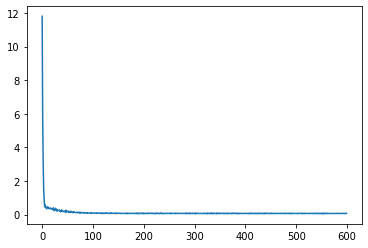

In [537]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.axes()

x = np.linspace(0, 10, 1000)
ax.plot([i for i in range(0,num_runs)], errs)

In [534]:
data_path = "../data/final.csv"

house_df = pd.read_csv(data_path, index_col=0)
house_df.head()

,num_room,full_sq,sport_count_5000,sport_count_3000,trc_count_5000,zd_vokzaly_avto_km,sadovoe_km,sport_count_2000,kremlin_km,bulvar_ring_km,...,exhibition_km,big_church_count_5000,sport_count_1000,office_sqm_1500,market_count_5000,school_education_centers_raion,museum_km,healthcare_centers_raion,big_church_km,price_doc
0,1.962264,43,52,21,52,14.231961,13.100618,10,15.156211,13.675657,...,7.023705,13,6,39554,4,5,7.389498,1,0.625783,5850000
1,1.925926,34,66,19,40,9.242586,6.444333,11,8.698054,8.132640,...,2.358840,15,2,102910,14,8,0.709260,1,0.967821,6000000
2,1.858586,43,67,20,35,9.540544,6.963403,8,9.067885,8.054252,...,4.958214,11,5,0,10,7,3.156423,1,3.178751,5700000
3,2.132275,89,26,18,22,17.478380,17.457198,13,19.487005,18.309433,...,5.029696,4,3,11000,3,10,16.041521,1,1.031777,13100000
4,2.875000,77,195,77,114,1.595898,0.046810,21,2.578671,0.787593,...,1.339652,135,7,1195735,14,9,1.800125,4,0.378756,16331452


In [396]:
house_df.isnull().values.any()

False

In [397]:
house_df.shape

(30292, 51)

In [514]:
target = "price_doc"
#drop_cols = ["trc_sqm_5000", "office_sqm_3000","trc_sqm_3000", "office_sqm_2000","office_sqm_1500"]
X = house_df.drop([target], axis=1)
y = house_df[target]/100000

In [515]:
 house_df[target].max()

111111112

In [516]:
X = (X-X.mean())/X.std()

In [517]:
X.head()

,num_room,full_sq,sport_count_5000,sport_count_3000,trc_count_5000,zd_vokzaly_avto_km,sadovoe_km,sport_count_2000,kremlin_km,bulvar_ring_km,...,leisure_count_5000,exhibition_km,big_church_count_5000,sport_count_1000,office_sqm_1500,market_count_5000,school_education_centers_raion,museum_km,healthcare_centers_raion,big_church_km
0,0.066648,-0.294743,-0.023969,0.034037,0.908218,-0.278913,-0.095951,0.010379,-0.086330,-0.142544,...,-0.421698,0.330972,-0.073117,0.920565,-0.336153,-0.413804,0.077751,0.095969,-0.220037,-0.604472
1,0.015886,-0.530798,0.278731,-0.072148,0.405766,-0.784951,-0.931297,0.118905,-0.886482,-0.826631,...,0.063017,-0.619788,-0.004582,-0.279003,-0.126630,1.633889,0.950815,-1.183847,-0.220037,-0.475748
2,-0.078182,-0.294743,0.300352,-0.019055,0.196410,-0.754732,-0.866155,-0.206674,-0.840660,-0.836305,...,-0.227812,-0.090002,-0.141653,0.620673,-0.466962,0.814812,0.659794,-0.715014,-0.220037,0.356323
3,0.304139,0.911760,-0.586126,-0.125241,-0.347913,0.050349,0.450789,0.335958,0.450247,0.429330,...,-0.421698,-0.075433,-0.381527,0.020889,-0.430584,-0.618574,1.532858,1.753546,-0.220037,-0.451679
4,1.341666,0.597020,3.067892,3.007236,3.504223,-1.560503,-1.734170,1.204169,-1.644660,-1.733114,...,3.989207,-0.827512,4.107555,1.220457,3.487437,1.633889,1.241836,-0.974857,1.788210,-0.697439


In [518]:
layers = 7
nodes = 9
activation = ReLU
loss = L2_loss
learning_rate = 0.000001
batch_size = 256
num_epochs = 200
anneal = 0.5

num_runs = math.ceil(X.shape[0]/batch_size)* num_epochs

test_nn = NeuralNetwork(layers, nodes, activation, loss, learning_rate, batch_size, anneal = anneal)

errs = test_nn.fit(X,y, num_epochs = num_epochs, print_iter = True)

(30292, 50)
23800(30292, 50)


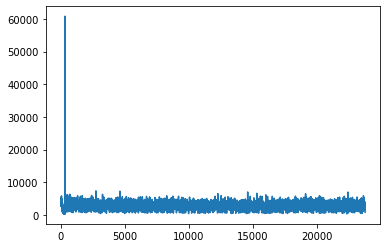

In [519]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.axes()

x = np.linspace(0, 10, 1000)
ax.plot([i for i in range(0,num_runs)], errs[0:])

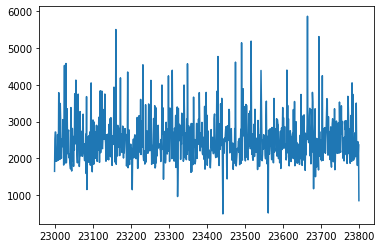

In [520]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.axes()

x = np.linspace(0, 10, 1000)
ax.plot([i for i in range(23000,num_runs)], errs[23000:])

In [521]:
preds = test_nn.predict(X)
rmse = np.sqrt(np.mean((preds-y)**2))
rmse

70.98207340659769

In [527]:
preds

array([19.02329017, 19.02329017, 19.02329017, ..., 19.02329017,
       19.02329017, 19.02329017])

In [524]:
y

0         58.50000
1         60.00000
2         57.00000
3        131.00000
4        163.31452
           ...    
30287     74.00000
30288    250.00000
30289     69.70959
30290    135.00000
30291     56.00000
Name: price_doc, Length: 30292, dtype: float64

In [523]:
y.std()

47.821700201078784

In [463]:
rmse - y.std()

656.4224920311912

In [464]:
preds[0]

63.174539642043854

In [281]:
y_test

150     4450000
151     7050000
152     1000000
153     6800000
154     1000000
         ...   
295     6150000
296     7400000
297    23300000
298     8750000
299     5200000
Name: price_doc, Length: 150, dtype: int64

In [508]:
from sklearn.datasets import make_moons
import numpy as np
from matplotlib import pyplot as plt

x,y = make_moons(n_samples=10000,noise=0.1)
x = x.astype('float32')
y = y.astype('float32')
y = np.expand_dims(y,axis=-1)

In [512]:
x.shape

(10000, 2)

In [510]:


layers = 3
nodes = 3
activation = ReLU
loss = L2_loss
learning_rate = 0.00001
batch_size = 128
num_epochs = 10
anneal = 0.5

num_runs = math.ceil(x.shape[0]/batch_size)* num_epochs

test_nn = NeuralNetwork(layers, nodes, activation, loss, learning_rate, batch_size, anneal = anneal)

errs = test_nn.fit(x,y, num_epochs = num_epochs, print_iter = True)

(10000, 2)
790(10000, 2)


In [511]:
x.shape

(10000, 2)

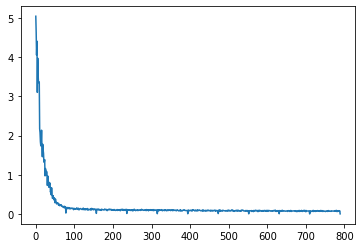

In [499]:


fig = plt.figure()
ax = plt.axes()

x = np.linspace(0, 10, 1000)
ax.plot([i for i in range(0,num_runs)], errs[0:])

In [ ]:
samp_size = 50
samp = df.sample(n=samp_size)


preds = test_nn.predict(samp.drop("target",axis=1))
rmse = np.sqrt(np.mean((preds-samp["target"])**2))
rmse

In [415]:
X.columns

Index(['num_room', 'full_sq', 'sport_count_5000', 'sport_count_3000',
       'trc_count_5000', 'zd_vokzaly_avto_km', 'sadovoe_km',
       'sport_count_2000', 'kremlin_km', 'bulvar_ring_km', 'office_sqm_5000',
       'ttk_km', 'trc_sqm_5000', 'sport_count_1500', 'nuclear_reactor_km',
       'sport_objects_raion', 'cafe_count_5000_price_1000', 'trc_count_3000',
       'cafe_count_5000_price_1500', 'cafe_count_5000',
       'cafe_count_5000_na_price', 'stadium_km', 'cafe_count_5000_price_500',
       'office_sqm_3000', 'cafe_count_5000_price_2500', 'trc_sqm_3000',
       'office_count_5000', 'basketball_km', 'office_km', 'office_sqm_2000',
       'detention_facility_km', 'cafe_count_5000_price_high',
       'church_count_5000', 'university_km', 'cafe_count_5000_price_4000',
       'swim_pool_km', 'theater_km', 'catering_km', 'workplaces_km',
       'thermal_power_plant_km', 'leisure_count_5000', 'exhibition_km',
       'big_church_count_5000', 'sport_count_1000', 'office_sqm_1500',
      

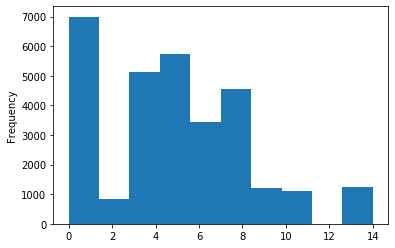

In [429]:
X["school_education_centers_raion"].plot.hist()

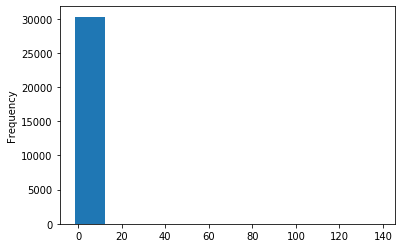

In [418]:
X["full_sq"].plot.hist()

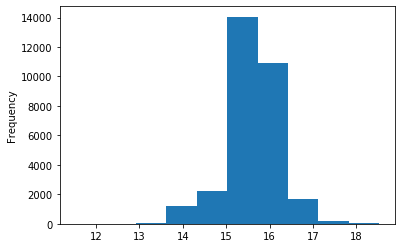

In [433]:
np.log(y).plot.hist()